**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & B. Keith Jenkins (bjenkins@usc.edu)

**Notebooks**: Written by Alexios Rustom (Chugg group PhD student) and Keith Chugg

# PCA for MNIST/FMNIST
In this notebook, we use PCA to reduce the dimension of the MNIST/FNIST data, down from the native 784 dimensions.  We first explore the amount of energy in the first d dimensions.  Then we used these features after PCA dimension reduction to perform a MSE classifier and observe how the accuracy varies with dimension.

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
from utils.previous_notebooks import load_MNIST_data

## Accessing and Inspecting the Data
First, let's get a function to get the MNIST or FMNIST data.

In [7]:
def setup_data(USE_FASHION_MNIST, visualize_sample_flag = False):
    x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)
    if USE_FASHION_MNIST:
        tag_name = 'FashionMNIST'
        label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    else:
        tag_name = 'MNIST'
        label_names = [f'{i}' for i in set(y_test)]
    if (visualize_sample_flag):
        plt.gray() # B/W Images
        plt.figure(figsize = (10,9)) # Adjusting figure size
        # Displaying a grid of 3x3 images
        for i in range(9):
            index = np.random.randint(low=0, high=len(y_train), dtype=int)
            plt.subplot(3,3,i+1)
            plt.imshow(x_train[index])
        plt.show()
    return x_train, y_train, x_test, y_test, tag_name, label_names

# PCA Dimension Reduction

We can perform PCA analysis using the standard NumPy Eigen routines.  

In [20]:
def energy_analysis(e_vals, k_max=200):
    H_W = len(e_vals)
    percent_energy = np.zeros(H_W)
    for k in range(H_W):
        percent_energy[k] = np.sum(e_vals[:k])
    percent_energy = 100 * percent_energy / np.sum(e_vals)
    plt.figure()
    plt.plot(np.arange(H_W), percent_energy, color='b', label='energy')
    plt.plot(np.arange(H_W), 100 - percent_energy, color='r', label='error energy')
    plt.axhline(95, color='b', linestyle='--', label='95%')
    plt.axhline(5, color='r', linestyle='--', label='5%')
    plt.grid(';')
    plt.legend()
    plt.xlim([0, k_max])
    plt.xlabel('eigen value index (max to min)')
    plt.ylabel('Percent Energy')
    plt.show()

    print(f'lambdas: {e_vals[:10]}')
    plt.figure()
    plt.stem(10 * np.log10(e_vals[:47]))
    plt.grid(';')
    plt.xlabel('eigen value index (max to min)')
    plt.ylabel('eigen value in dB')
    
    return percent_energy

def data_normalization_PCA_evaluation(x_train, x_test, k_max=200):
    x_train_float = x_train.astype("float32") 
    x_test_float = x_test.astype("float32")

    X_train = x_train_float.reshape(len(x_train_float),-1) / 255
    X_test = x_test_float.reshape(len(x_test_float),-1) / 255

    X_train = X_train - np.mean(X_train)
    X_test = X_test - np.mean(X_test)
    
    print(f'X_train.shape: {X_train.shape}')
    N = x_train.shape[0]
    Kx_train = X_train.T @ X_train / N ## sample covariance matrix
    e_vals_train, E_vecs_train = np.linalg.eig(Kx_train)
    e_vals_train = e_vals_train.real
    E_vecs_train = E_vecs_train.T.real
    small_to_big_train = np.argsort(e_vals_train)
    big_to_small_train = small_to_big_train[::-1]
    e_vals_train = e_vals_train[big_to_small_train]
    E_vecs_train = E_vecs_train[big_to_small_train]
    print('Eigenvalues and Eigenvectors are calculated')
    percent_energy = energy_analysis(e_vals_train)
    return X_train, X_test, E_vecs_train, percent_energy

OK, now we are ready to perform PCA and look at the energy as a function of dimension.

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 5923 train images ( 9.87 %), 980 test images ( 9.80 %) 
Class 1: has 6742 train images ( 11.24 %), 1135 test images ( 11.35 %) 
Class 2: has 5958 train images ( 9.93 %), 1032 test images ( 10.32 %) 
Class 3: has 6131 train images ( 10.22 %), 1010 test images ( 10.10 %) 
Class 4: has 5842 train images ( 9.74 %), 982 test images ( 9.82 %) 
Class 5: has 5421 train images ( 9.04 %), 892 test images ( 8.92 %) 
Class 6: has 5918 train images ( 9.86 %), 958 test images ( 9.58 %) 
Class 7: has 6265 train images ( 10.44 %), 1028 test images ( 10.28 %) 
Class 8: has 5851 train images ( 9.75 %), 974 test images ( 9.74 %) 
Class 9: has 5949 train images ( 9.91 %), 1009 test images ( 10.09 %) 
X_train.shape: (60000, 784)
Eigenvalues and Eigenvectors are calculated


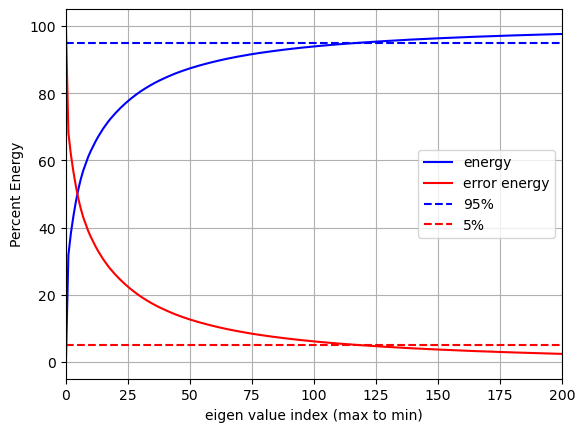

lambdas: [23.64801    4.8122015  3.7411125  3.22994    2.7784173  2.2737274
  1.9208053  1.5328662  1.5019106  1.2500274]


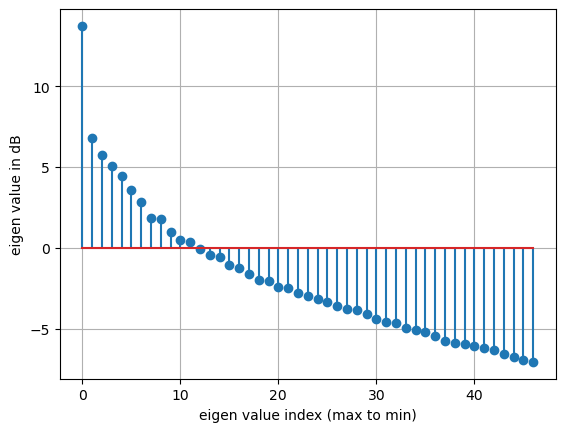

In [21]:
USE_FASHION_MNIST = False

x_train, y_train, x_test, y_test, tag_name, label_names = setup_data(USE_FASHION_MNIST, visualize_sample_flag = False)

X_train, X_test, E_vecs_train, percent_energy = data_normalization_PCA_evaluation(x_train, x_test, k_max=300)

Now let's visualize the approximations as a function of the number of dimensions used.

<Figure size 640x480 with 0 Axes>

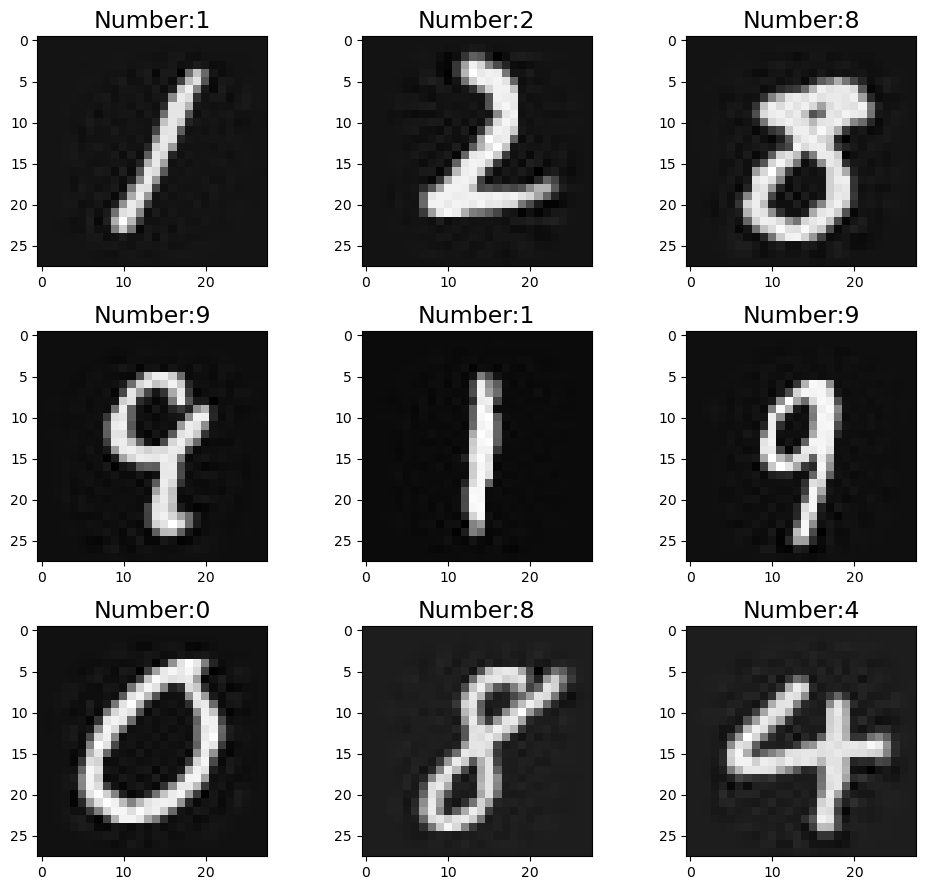

In [24]:
k_max = 300
coeff =  (E_vecs_train[:k_max] @ X_train.T).T
X_approx = coeff @ E_vecs_train[:k_max]
X_approx = X_approx.reshape(X_train.shape[0], 28, 28)

plt.gray() # B/W Images
plt.figure(figsize = (10,9))
# Displaying a grid of 3x3 images
for i in range(9):
    index = np.random.randint(low=0, high=len(y_train), dtype=int)
    plt.subplot(3,3,i+1)
    plt.imshow(X_approx[index])
    plt.title("Number:{}".format(y_train[index]),fontsize = 17)
plt.tight_layout()
plt.show()

